In [1]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader, LinkNeighborLoader
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, GCNConv, Node2Vec
from torch_geometric.utils import to_networkx, negative_sampling, train_test_split_edges

In [5]:
node_df = pd.read_csv('filtered-artist.csv')
edges_df = pd.read_csv('filtered-influence.csv')

In [6]:
node_df.head()

,artist_name,artist_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity,count
0,Frank Sinatra,792507,0.384478,0.238017,0.364288,110.181698,-14.271141,1,5,0.735648,0.020855,0.232106,0.049614,189179.9255,26.004383,1369
1,Vladimir Horowitz,119107,0.343210,0.118844,0.225951,94.900679,-23.193418,1,1,0.990070,0.879508,0.183812,0.043360,266541.1251,3.592378,1207
2,Johnny Cash,816890,0.619803,0.449381,0.680662,115.037747,-11.593104,1,10,0.685637,0.022647,0.242243,0.098216,162279.2672,26.614130,1104
3,Billie Holiday,79016,0.572637,0.201368,0.498934,109.912172,-13.225966,1,5,0.908499,0.013064,0.217727,0.062432,185131.4530,15.621005,1095
4,Bob Dylan,66915,0.512598,0.477932,0.551934,126.160149,-11.184330,1,7,0.562567,0.034211,0.308978,0.064535,256713.4203,30.860806,1092


In [7]:
df1 = edges_df[['influencer_id', 'influencer_name', 'influencer_main_genre', 'influencer_active_start']]
df2 = edges_df[['follower_id','follower_name', 'follower_main_genre', 'follower_active_start']]
col_names = ['artist_id', 'artist_name', 'genre', 'active_start_year']
df1.columns = col_names
df2.columns = col_names
df3 = pd.concat([df1, df2], ignore_index=True)

In [8]:
df3 = df3.drop_duplicates().reset_index().drop(columns = ['index'])
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5440 entries, 0 to 5439
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   artist_id          5440 non-null   int64 
 1   artist_name        5440 non-null   object
 2   genre              5440 non-null   object
 3   active_start_year  5440 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 170.1+ KB


In [9]:
node_df = pd.merge(node_df, df3, on = ['artist_id', 'artist_name'],how='left')

In [10]:
node_df['genre'] = node_df['genre'].fillna('unknown')
#node_df['active_start_year'].fillna()

## Process Node Attributes

In [11]:
node_df["artist_id"] = node_df["artist_id"].astype(str)
#node_df.reset_index(inplace=True)

In [12]:
# Normalize popularity and follower features
node_df["popularity_norm"] = MinMaxScaler().fit_transform(node_df[["popularity"]])
node_df["log_duration_ms"] = np.log(node_df["duration_ms"])

In [13]:
node_df["year"] = 2023 - node_df["active_start_year"]

In [14]:
# Data on each artist 
node_df

,artist_name,artist_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,...,liveness,speechiness,duration_ms,popularity,count,genre,active_start_year,popularity_norm,log_duration_ms,year
0,Frank Sinatra,792507,0.384478,0.238017,0.364288,110.181698,-14.271141,1,5,0.735648,...,0.232106,0.049614,189179.9255,26.004383,1369,Vocal,1930.0,0.321042,12.150454,93.0
1,Vladimir Horowitz,119107,0.343210,0.118844,0.225951,94.900679,-23.193418,1,1,0.990070,...,0.183812,0.043360,266541.1251,3.592378,1207,unknown,NaN,0.044350,12.493284,NaN
2,Johnny Cash,816890,0.619803,0.449381,0.680662,115.037747,-11.593104,1,10,0.685637,...,0.242243,0.098216,162279.2672,26.614130,1104,Country,1950.0,0.328570,11.997074,73.0
3,Billie Holiday,79016,0.572637,0.201368,0.498934,109.912172,-13.225966,1,5,0.908499,...,0.217727,0.062432,185131.4530,15.621005,1095,Vocal,1930.0,0.192852,12.128821,93.0
4,Bob Dylan,66915,0.512598,0.477932,0.551934,126.160149,-11.184330,1,7,0.562567,...,0.308978,0.064535,256713.4203,30.860806,1092,Pop/Rock,1960.0,0.380998,12.455716,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5843,Natalie La Rose,3359519,0.830000,0.520000,0.735000,104.990000,-8.714000,1,0,0.000792,...,0.065600,0.037600,189907.0000,64.000000,1,R&B;,2010.0,0.790123,12.154290,13.0
5844,Sarah Ross,3381566,0.721000,0.944000,0.626000,85.002000,-5.982000,1,8,0.013000,...,0.320000,0.159000,262760.0000,52.000000,1,Country,2010.0,0.641975,12.478996,13.0
5845,Rotimi,3410250,0.637000,0.501000,0.431000,103.993000,-6.148000,0,0,0.229000,...,0.099000,0.187000,185461.0000,71.000000,1,R&B;,2010.0,0.876543,12.130600,13.0
5846,Jillian Jacqueline,3455945,0.547000,0.672000,0.283000,155.791000,-5.023000,1,11,0.304000,...,0.099600,0.049600,213133.0000,58.000000,1,Country,2000.0,0.716049,12.269672,23.0


In [15]:
node_df.shape

(5848, 21)

In [16]:
node_df.describe()

,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity,count,active_start_year,popularity_norm,log_duration_ms,year
count,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5848.000000,5.848000e+03,5848.000000,5848.00000,5440.000000,5848.000000,5848.000000,5440.000000
mean,0.545409,0.585322,0.545063,120.342607,-9.958473,0.821306,5.514022,0.343748,0.132456,0.195793,0.069708,2.463314e+05,39.589885,33.95212,1975.312500,0.488764,12.369914,47.687500
std,0.135132,0.216065,0.200264,19.166747,4.180762,0.383128,3.518060,0.294873,0.233617,0.116188,0.075387,8.368608e+04,13.233096,77.85483,19.503248,0.163372,0.289845,19.503248
min,0.080400,0.001980,0.027850,30.946000,-40.147000,0.000000,0.000000,0.000001,0.000000,0.011600,0.023200,4.570700e+04,0.000000,1.00000,1930.000000,0.000000,10.730007,13.000000
25%,0.460333,0.430000,0.409617,109.447125,-12.240537,1.000000,2.000000,0.081520,0.000097,0.124989,0.038143,1.972259e+05,32.333333,4.00000,1960.000000,0.399177,12.192105,33.000000
50%,0.550201,0.597915,0.554000,119.299058,-9.529583,1.000000,6.000000,0.268166,0.008815,0.170000,0.048662,2.349928e+05,40.257835,10.00000,1980.000000,0.497010,12.367310,43.000000
75%,0.636850,0.750860,0.689000,129.838143,-6.866336,1.000000,9.000000,0.577308,0.143051,0.229383,0.072870,2.762292e+05,48.500000,31.00000,1990.000000,0.598765,12.528986,63.000000
max,0.962000,0.999500,0.980000,206.680000,1.342000,1.000000,11.000000,0.996000,0.973000,0.973000,0.958000,1.640000e+06,81.000000,1369.00000,2010.000000,1.000000,14.310207,93.000000


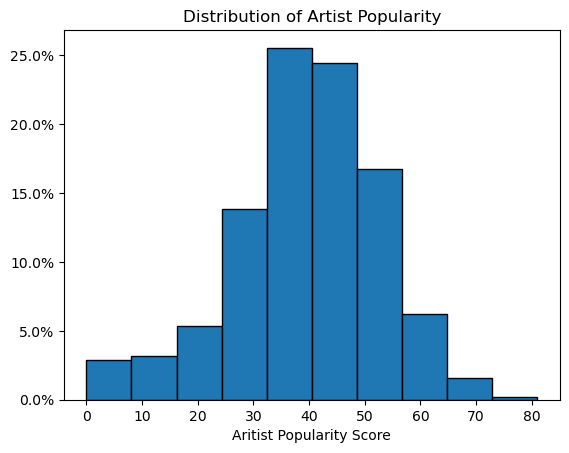

In [17]:
# Distribution of artist popularity
#node_df["popularity"].hist()
from matplotlib.ticker import PercentFormatter

plt.hist(node_df["popularity"], weights=np.ones(len(node_df)) / len(node_df), edgecolor='black')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Aritist Popularity Score")
plt.title("Distribution of Artist Popularity")
plt.show()

<AxesSubplot:>

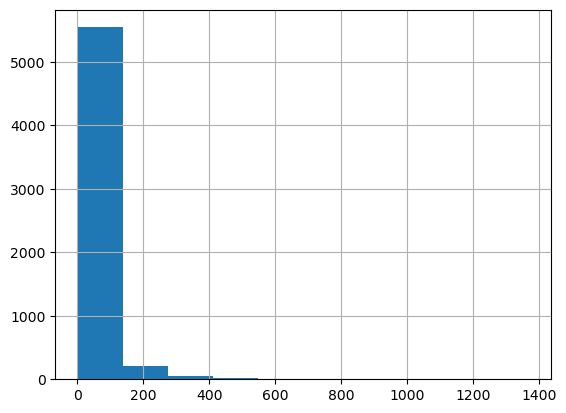

In [18]:
node_df["count"].hist()

In [19]:
node_df['log_count'] = np.log(node_df['count'])

<AxesSubplot:>

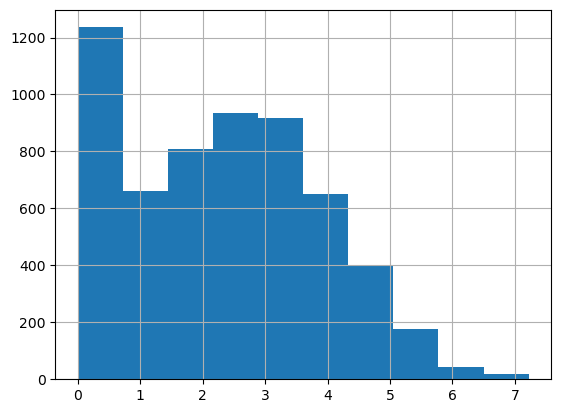

In [20]:
node_df["log_count"].hist()

In [21]:
follower_num = pd.DataFrame(edges_df.groupby('influencer_id')['influencer_id'].count())
follower_num['artist_id'] = follower_num.index.astype(str)
follower_num.columns = ['follower_num','artist_id']

In [22]:
influencer_num = pd.DataFrame(edges_df.groupby('follower_id')['follower_id'].count())
influencer_num['artist_id'] = influencer_num.index.astype(str)
influencer_num.columns = ['influencer_num','artist_id']

In [23]:
node_df = pd.merge(node_df,follower_num , on = ['artist_id'],how='left')
node_df = pd.merge(node_df,influencer_num , on = ['artist_id'],how='left')

In [24]:
node_df = node_df.fillna(0)
node_df

,artist_name,artist_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,...,popularity,count,genre,active_start_year,popularity_norm,log_duration_ms,year,log_count,follower_num,influencer_num
0,Frank Sinatra,792507,0.384478,0.238017,0.364288,110.181698,-14.271141,1,5,0.735648,...,26.004383,1369,Vocal,1930.0,0.321042,12.150454,93.0,7.221836,70.0,9.0
1,Vladimir Horowitz,119107,0.343210,0.118844,0.225951,94.900679,-23.193418,1,1,0.990070,...,3.592378,1207,unknown,0.0,0.044350,12.493284,0.0,7.095893,0.0,0.0
2,Johnny Cash,816890,0.619803,0.449381,0.680662,115.037747,-11.593104,1,10,0.685637,...,26.614130,1104,Country,1950.0,0.328570,11.997074,73.0,7.006695,112.0,11.0
3,Billie Holiday,79016,0.572637,0.201368,0.498934,109.912172,-13.225966,1,5,0.908499,...,15.621005,1095,Vocal,1930.0,0.192852,12.128821,93.0,6.998510,101.0,2.0
4,Bob Dylan,66915,0.512598,0.477932,0.551934,126.160149,-11.184330,1,7,0.562567,...,30.860806,1092,Pop/Rock,1960.0,0.380998,12.455716,63.0,6.995766,386.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5843,Natalie La Rose,3359519,0.830000,0.520000,0.735000,104.990000,-8.714000,1,0,0.000792,...,64.000000,1,R&B;,2010.0,0.790123,12.154290,13.0,0.000000,0.0,5.0
5844,Sarah Ross,3381566,0.721000,0.944000,0.626000,85.002000,-5.982000,1,8,0.013000,...,52.000000,1,Country,2010.0,0.641975,12.478996,13.0,0.000000,0.0,5.0
5845,Rotimi,3410250,0.637000,0.501000,0.431000,103.993000,-6.148000,0,0,0.229000,...,71.000000,1,R&B;,2010.0,0.876543,12.130600,13.0,0.000000,0.0,1.0
5846,Jillian Jacqueline,3455945,0.547000,0.672000,0.283000,155.791000,-5.023000,1,11,0.304000,...,58.000000,1,Country,2000.0,0.716049,12.269672,23.0,0.000000,0.0,6.0


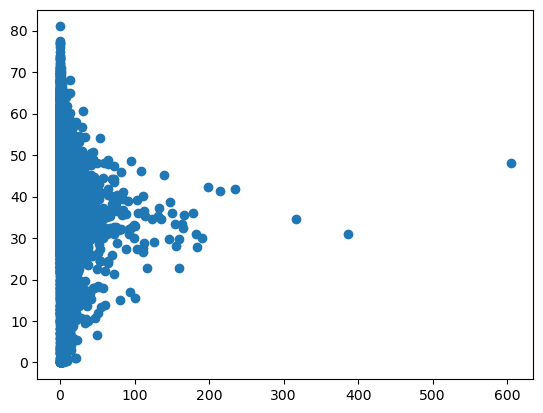

In [25]:
#node_df["log_followers"] = np.log(node_df["follower_num"])
# Correlation between followers and popularity
node_df["follower_num"].corr(node_df["popularity"])
plt.scatter(node_df["follower_num"], node_df["popularity"])
plt.show()

Logarithmic relationship between followers and popularity

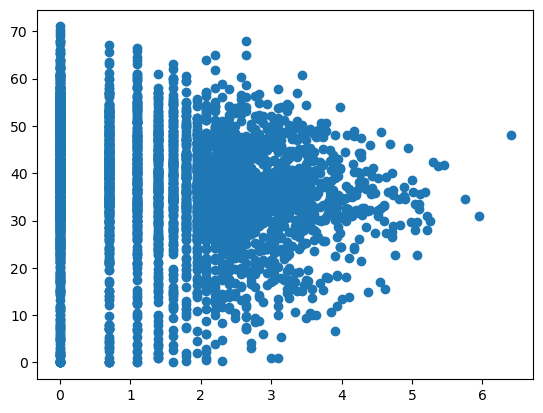

In [26]:
nonzero_nodes = node_df.loc[node_df["follower_num"]>0]
plt.scatter(np.log(nonzero_nodes["follower_num"]), nonzero_nodes["popularity"])
plt.show()

In [27]:
node_df['log_followers'] = np.log(node_df['follower_num'])
node_df = node_df.copy()
node_df['log_followers'][np.isinf(node_df['log_followers'])] = np.nan
node_df['log_influencers'] = np.log(node_df['influencer_num'])
node_df = node_df.copy()
node_df['log_influencers'][np.isinf(node_df['log_influencers'])] = np.nan

/Users/xujinwen/Conda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rs/_y7gb8yj2k7_qnpt5zsnl19c0000gn/T/ipykernel_21669/2542799124.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_df['log_followers'][np.isinf(node_df['log_followers'])] = np.nan
/Users/xujinwen/Conda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rs/_y7gb8yj2k7_qnpt5zsnl19c0000gn/T/ipykernel_21669/2542799124.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [28]:
node_df["popularity"].corr(node_df["log_followers"])

-0.13151172829171237

In [29]:
node_df["popularity"].corr(node_df["log_influencers"])

0.09863439410186545

In [30]:
# Generate dummy variables for each music genre 
genres = node_df['genre'].str.get_dummies(', ')
node_df = pd.concat([node_df, genres], axis = 1)

In [31]:
node_df.reset_index(inplace=True)
node_df.reset_index(inplace=True)

In [32]:
node_df.columns

Index(['level_0', 'index', 'artist_name', 'artist_id', 'danceability',
       'energy', 'valence', 'tempo', 'loudness', 'mode', 'key', 'acousticness',
       'instrumentalness', 'liveness', 'speechiness', 'duration_ms',
       'popularity', 'count', 'genre', 'active_start_year', 'popularity_norm',
       'log_duration_ms', 'year', 'log_count', 'follower_num',
       'influencer_num', 'log_followers', 'log_influencers', 'Avant-Garde',
       'Blues', 'Children's', 'Classical', 'Comedy/Spoken', 'Country',
       'Easy Listening', 'Electronic', 'Folk', 'International', 'Jazz',
       'Latin', 'New Age', 'Pop/Rock', 'R&B;', 'Reggae', 'Religious',
       'Stage & Screen', 'Vocal', 'unknown'],
      dtype='object')

In [33]:
features = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'mode', 'key',
       'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'popularity_norm',
       'log_duration_ms', 'log_count','log_followers', 'log_influencers', 'Avant-Garde',
       'Blues', 'Children\'s', 'Classical', 'Comedy/Spoken', 'Country','Easy Listening', 'Electronic', 'Folk', 'International', 'Jazz',
       'Latin', 'New Age', 'Pop/Rock', 'R&B;', 'Reggae', 'Religious',
       'Stage & Screen', 'Vocal','unknown']

In [34]:
features_1 = ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'mode', 'key',
       'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'popularity_norm',
       'log_duration_ms', 'log_count','Avant-Garde',
       'Blues', 'Children\'s', 'Classical', 'Comedy/Spoken', 'Country','Easy Listening', 'Electronic', 'Folk', 'International', 'Jazz',
       'Latin', 'New Age', 'Pop/Rock', 'R&B;', 'Reggae', 'Religious',
       'Stage & Screen', 'Vocal','unknown']

In [35]:
#node_ids = node_df["spotify_id"]
node_attrs = torch.tensor(node_df[features].values, dtype=torch.float)

In [36]:
# FUll dataset: 156222
len(node_attrs)

5848

In [37]:
node_attrs.shape

torch.Size([5848, 36])

## Process Edges

In [38]:
# Edge list of collaborations between artists 
edges_df = pd.read_csv('filtered-influence.csv')
edges_df

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start
0,759491,The Exploited,Pop/Rock,1980,74,Special Duties,Pop/Rock,1980
1,759491,The Exploited,Pop/Rock,1980,55778,The Casualties,Pop/Rock,1990
2,101701,Conflict,Pop/Rock,1980,55778,The Casualties,Pop/Rock,1990
3,184267,U.K. Subs,Pop/Rock,1970,55778,The Casualties,Pop/Rock,1990
4,759491,The Exploited,Pop/Rock,1980,258430,Pennywise,Pop/Rock,1980
...,...,...,...,...,...,...,...,...
41412,3161008,The Neptunes,R&B;,1960,3306945,Kaytranada,Electronic,2010
41413,580300,Sufjan Stevens,Pop/Rock,1990,3366296,The Oh Hellos,Pop/Rock,2010
41414,588246,Los Campesinos!,Pop/Rock,2000,3366296,The Oh Hellos,Pop/Rock,2010
41415,1507678,The Middle East,Pop/Rock,2000,3366296,The Oh Hellos,Pop/Rock,2010


In [39]:
edges_df = edges_df[['influencer_id','follower_id']]
edges_df.columns = ['id_0','id_1']

In [40]:
artist_key = node_df[["level_0", "artist_id"]]
artist_key.columns = ["influencer", "id_0"]
artist_key = artist_key.copy()
artist_key['id_0'] = artist_key['id_0'].astype('int')
edges_df_merge = edges_df.merge(artist_key,how = 'left', on = 'id_0')

In [41]:
edges_df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41417 entries, 0 to 41416
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id_0        41417 non-null  int64
 1   id_1        41417 non-null  int64
 2   influencer  41417 non-null  int64
dtypes: int64(3)
memory usage: 1.3 MB


In [42]:
artist_key.columns = ["follower", "id_1"]

In [43]:
edges_df_merge = edges_df_merge.merge(artist_key,how = 'left', on = 'id_1')

In [44]:
edges_df_merge

,id_0,id_1,influencer,follower
0,759491,74,2543,4612
1,759491,55778,2543,4704
2,101701,55778,2900,4704
3,184267,55778,4921,4704
4,759491,258430,2543,1196
...,...,...,...,...
41412,3161008,3306945,3868,3414
41413,580300,3366296,1015,3097
41414,588246,3366296,5254,3097
41415,1507678,3366296,5616,3097


In [45]:
edges_df_merge.drop(["id_0", "id_1"], axis=1, inplace=True)

In [46]:
edges = torch.tensor(edges_df_merge.values, dtype=torch.long)
edges

tensor([[2543, 4612],
        [2543, 4704],
        [2900, 4704],
        ...,
        [5254, 3097],
        [5616, 3097],
        [ 693, 3097]])

## Load Data into Graph

In [81]:
# Create the graph object 
graph = Data(x=node_attrs, edge_index=edges.t().contiguous())

In [82]:
graph

Data(x=[5848, 36], edge_index=[2, 41417])

In [83]:
graph.edge_index

tensor([[2543, 2543, 2900,  ..., 5254, 5616,  693],
        [4612, 4704, 4704,  ..., 3097, 3097, 3097]])

In [90]:
print(graph.num_nodes)
print(graph.num_edges)
print(graph.num_node_features)
print(graph.has_isolated_nodes())
print(graph.has_self_loops())
print(graph.is_directed())

5848
41417
36
True
False
True


In [51]:
G = to_networkx(graph, to_undirected=True) # Convert to networkx graph

In [94]:
nx.number_of_isolates(G)

773

## Negative Sampling and Train-Test Split

In [52]:
# Perform negative sampling of edges 
neg_sample = negative_sampling(edge_index=graph.edge_index, #positive edges
                               num_nodes=graph.num_nodes, # number of nodes
                               num_neg_samples=graph.edge_index.size(1)) # number of neg_sample equal to number of pos_edges

In [53]:
# Combine positive and negative edges for a full sample 
full_sample = torch.cat((graph.edge_index, neg_sample), 1)

In [54]:
full_sample

tensor([[2543, 2543, 2900,  ..., 2889, 3136,  643],
        [4612, 4704, 4704,  ..., 1408, 1724, 2531]])

In [55]:
full_sample.shape

torch.Size([2, 82834])

In [56]:
# Create the labels for the full sample 
lbls = np.concatenate((np.ones(graph.edge_index.shape[1]), np.zeros(graph.edge_index.shape[1])))

In [57]:
len(lbls)

82834

In [58]:
# Create a training graph by randomly removing a portion of the existing edges (in this case 30%)
train_edges, supervision_edges = train_test_split(graph.edge_index.T.numpy(), test_size=0.3, random_state=42)
t_edges = torch.tensor(train_edges, dtype=torch.long)
train_graph = Data(x=node_attrs, edge_index=t_edges.t().contiguous()) # Pytorch Geometric graph
trainG = to_networkx(train_graph, to_undirected=True) # NetworkX graph for Jaccard and Adamic-Adar

In [59]:
train_graph

Data(x=[5848, 36], edge_index=[2, 28991])

In [60]:
graph

Data(x=[5848, 36], edge_index=[2, 41417])

In [61]:
train_graph.edge_index.shape[1]/graph.edge_index.shape[1] # Confirm 70% of edges remaining

0.6999782697925973

In [62]:
# Sample of edges in training graph and equal number of negative edges
train_sample = torch.cat((t_edges.t(), neg_sample[:,:train_edges.shape[0]]), 1)
train_sample

tensor([[ 368,  670,  995,  ..., 1828, 1738, 3753],
        [ 976,  688, 1138,  ..., 2202, 3414, 2607]])

In [63]:
# Labels for the training sample
train_lbls = np.concatenate((np.ones(train_edges.shape[0]), np.zeros(train_edges.shape[0])))
train_lbls

array([1., 1., 1., ..., 0., 0., 0.])

In [64]:
# Test sample of removed/masked edges and equal number of negative edges
test_sample = torch.cat((torch.tensor(supervision_edges).t(), neg_sample[:,train_edges.shape[0]:]), 1)
test_sample

tensor([[1299,   63,  780,  ..., 2889, 3136,  643],
        [ 553, 2002,  160,  ..., 1408, 1724, 2531]])

In [65]:
test_sample.shape

torch.Size([2, 24852])

In [66]:
# Labels for the test sample
test_lbls = np.concatenate((np.ones(int(test_sample.shape[1]/2)), np.zeros(int(test_sample.shape[1]/2))))
test_lbls.shape

(24852,)

## Link Prediction Using Jaccard

In [128]:
# Calculate Jaccard Measure for all edges in sample
jac = list(nx.jaccard_coefficient(trainG, full_sample.T.numpy()))
jac[0:10]

[(2543, 4612, 0.0),
 (2543, 4704, 0.0),
 (2900, 4704, 0.0),
 (4921, 4704, 0.0),
 (2543, 1196, 0.0),
 (484, 1196, 0.014285714285714285),
 (624, 1196, 0.05),
 (1257, 1196, 0.0),
 (194, 1196, 0.05263157894736842),
 (2100, 1196, 0.05)]

In [129]:
# Calculate Jaccard Measure for training edges
train_jac = list(nx.jaccard_coefficient(trainG, train_sample.T.numpy()))
train_jac[0:10]

[(368, 976, 0.03125),
 (670, 688, 0.0),
 (995, 1138, 0.05555555555555555),
 (2257, 38, 0.0),
 (976, 5150, 0.14285714285714285),
 (35, 5584, 0.0),
 (1091, 204, 0.03389830508474576),
 (827, 1176, 0.04),
 (1024, 369, 0.03125),
 (4124, 3583, 0.0)]

In [130]:
# Calculate Jaccard Measure for supervision (test) edges
test_jac = list(nx.jaccard_coefficient(trainG, test_sample.T.numpy()))
test_jac[0:10]

[(1299, 553, 0.0),
 (63, 2002, 0.0),
 (780, 160, 0.0425531914893617),
 (79, 3450, 0.011235955056179775),
 (160, 578, 0.0),
 (341, 1405, 0.02127659574468085),
 (951, 403, 0.0),
 (91, 902, 0.043478260869565216),
 (1339, 3275, 0.0),
 (1757, 2843, 0.0975609756097561)]

In [131]:
df = pd.DataFrame(jac, columns =['Artist1', 'Artist2', 'Jaccard'])
df

,Artist1,Artist2,Jaccard
0,2543,4612,0.0
1,2543,4704,0.0
2,2900,4704,0.0
3,4921,4704,0.0
4,2543,1196,0.0
...,...,...,...
82829,1319,5234,0.0
82830,1176,3047,0.0
82831,2889,1408,0.0
82832,3136,1724,0.0


In [132]:
train_df = pd.DataFrame(train_jac, columns =['Artist1', 'Artist2', 'Jaccard'])
train_df

,Artist1,Artist2,Jaccard
0,368,976,0.031250
1,670,688,0.000000
2,995,1138,0.055556
3,2257,38,0.000000
4,976,5150,0.142857
...,...,...,...
57977,3424,2602,0.000000
57978,2022,4164,0.000000
57979,1828,2202,0.000000
57980,1738,3414,0.000000


In [133]:
test_df = pd.DataFrame(test_jac, columns =['Artist1', 'Artist2', 'Jaccard'])
test_df

,Artist1,Artist2,Jaccard
0,1299,553,0.000000
1,63,2002,0.000000
2,780,160,0.042553
3,79,3450,0.011236
4,160,578,0.000000
...,...,...,...
24847,1319,5234,0.000000
24848,1176,3047,0.000000
24849,2889,1408,0.000000
24850,3136,1724,0.000000


In [134]:
train_df["lbl"] = train_lbls
test_df["lbl"] = test_lbls

In [135]:
train_df[["Jaccard"]]

,Jaccard
0,0.031250
1,0.000000
2,0.055556
3,0.000000
4,0.142857
...,...
57977,0.000000
57978,0.000000
57979,0.000000
57980,0.000000


In [136]:
train_df["lbl"]

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
57977    0.0
57978    0.0
57979    0.0
57980    0.0
57981    0.0
Name: lbl, Length: 57982, dtype: float64

In [145]:
# Train classifier
jac_model1 = LogisticRegression(random_state=7).fit(train_df[["Jaccard"]], train_df["lbl"])
jac_model2 = RandomForestClassifier(random_state=8).fit(train_df[["Jaccard"]], train_df["lbl"])
jac_model3 = SVC(random_state=9,probability = True).fit(train_df[["Jaccard"]], train_df["lbl"])
# jac_model4 = LGBMClassifier(random_state=51).fit(train_df[["Jaccard"]], train_df["lbl"])
# jac_model5 = AdaBoostClassifier(random_state=61).fit(train_df[["Jaccard"]], train_df["lbl"])
jac_model6 = KNeighborsClassifier().fit(train_df[["Jaccard"]], train_df["lbl"])
jac_model7 = GradientBoostingClassifier().fit(train_df[["Jaccard"]], train_df["lbl"])
jac_model8 = DecisionTreeClassifier().fit(train_df[["Jaccard"]], train_df["lbl"])

In [146]:
# Generate predictions for test set
preds1 = jac_model1.predict(test_df[["Jaccard"]])
probs1 = jac_model1.predict_proba(test_df[["Jaccard"]])
preds2 = jac_model2.predict(test_df[["Jaccard"]])
probs2 = jac_model2.predict_proba(test_df[["Jaccard"]])
preds3 = jac_model3.predict(test_df[["Jaccard"]])
probs3 = jac_model3.predict_proba(test_df[["Jaccard"]])
# preds4 = jac_model4.predict(test_df[["Jaccard"]])
# probs4 = jac_model4.predict_proba(test_df[["Jaccard"]])
# preds5 = jac_model5.predict(test_df[["Jaccard"]])
# probs5 = jac_model5.predict_proba(test_df[["Jaccard"]])
preds6 = jac_model6.predict(test_df[["Jaccard"]])
probs6 = jac_model6.predict_proba(test_df[["Jaccard"]])
preds7 = jac_model7.predict(test_df[["Jaccard"]])
probs7 = jac_model7.predict_proba(test_df[["Jaccard"]])
preds8 = jac_model8.predict(test_df[["Jaccard"]])
probs8 = jac_model8.predict_proba(test_df[["Jaccard"]])

/Users/xujinwen/Conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [140]:
print(roc_auc_score(test_df["lbl"], preds1))
print(roc_auc_score(test_df["lbl"], preds2))
print(roc_auc_score(test_df["lbl"], preds3))
# print(roc_auc_score(test_df["lbl"], preds4))
# print(roc_auc_score(test_df["lbl"], preds5))
print(roc_auc_score(test_df["lbl"], preds6))
print(roc_auc_score(test_df["lbl"], preds7))
print(roc_auc_score(test_df["lbl"], preds8))

0.7302430387896347
0.7456542732979238
0.7443264123611781
0.49979880894897794
0.745976178979559
0.7455335586673104


In [157]:
print(accuracy_score(test_df["lbl"], preds1))
print(accuracy_score(test_df["lbl"], preds2))
print(accuracy_score(test_df["lbl"], preds3))
# print(accuracy_score(test_df["lbl"], preds4))
# print(accuracy_score(test_df["lbl"], preds5))
print(accuracy_score(test_df["lbl"], preds6))
print(accuracy_score(test_df["lbl"], preds7))
print(accuracy_score(test_df["lbl"], preds8))

0.745976178979559
0.7453323676162884
0.745976178979559
0.5
0.7456542732979237
0.744608079832609


In [165]:
print(f1_score(test_df["lbl"], preds1))
print(f1_score(test_df["lbl"], preds2))
print(f1_score(test_df["lbl"], preds3))
# print(f1_score(test_df["lbl"], preds4))
# print(f1_score(test_df["lbl"], preds5))
print(f1_score(test_df["lbl"], preds6))
print(f1_score(test_df["lbl"], preds7))
print(f1_score(test_df["lbl"], preds8))

0.6407663650878126
0.6693737310635639
0.6667709963484612
0.6697199958363692
0.6697199958363692
0.6665593561368209
0.6697199958363692
0.6691658856607311


## Link Prediction Using Adamic Adar

In [149]:
adamic = list(nx.adamic_adar_index(trainG, full_sample.T.numpy()))
adamic[0:10]

[(2543, 4612, 0),
 (2543, 4704, 0),
 (2900, 4704, 0),
 (4921, 4704, 0),
 (2543, 1196, 0),
 (484, 1196, 0.2729584204093974),
 (624, 1196, 0.2442393366759723),
 (1257, 1196, 0),
 (194, 1196, 0.8441197443836421),
 (2100, 1196, 0.2227848098240302)]

In [150]:
# Calculate Jaccard Measure for training edges
train_adamic = list(nx.adamic_adar_index(trainG, train_sample.T.numpy()))
train_adamic[0:10]

[(368, 976, 0.16746879082346372),
 (670, 688, 0),
 (995, 1138, 0.45511961331341866),
 (2257, 38, 0),
 (976, 5150, 0.4271990929957353),
 (35, 5584, 0),
 (1091, 204, 0.35350566634054614),
 (827, 1176, 0.23233849357411737),
 (1024, 369, 0.5581106265512472),
 (4124, 3583, 0)]

In [151]:
# Calculate Jaccard Measure for supervision (test) edges
test_adamic = list(nx.adamic_adar_index(trainG, test_sample.T.numpy()))
test_adamic[0:10]

[(1299, 553, 0),
 (63, 2002, 0),
 (780, 160, 0.5367381638923188),
 (79, 3450, 0.23307527170850925),
 (160, 578, 0),
 (341, 1405, 0.21959311237518594),
 (951, 403, 0),
 (91, 902, 0.7213475204444817),
 (1339, 3275, 0),
 (1757, 2843, 1.9149772497927549)]

In [152]:
adamic_df = pd.DataFrame(adamic, columns =['Artist1', 'Artist2', 'Adamic'])
#adamic_df["lbl"] = lbls
adamic_df

,Artist1,Artist2,Adamic
0,2543,4612,0.0
1,2543,4704,0.0
2,2900,4704,0.0
3,4921,4704,0.0
4,2543,1196,0.0
...,...,...,...
82829,1319,5234,0.0
82830,1176,3047,0.0
82831,2889,1408,0.0
82832,3136,1724,0.0


In [153]:
train_adamic_df = pd.DataFrame(train_adamic, columns =['Artist1', 'Artist2', 'Adamic'])
train_adamic_df["lbl"] = train_lbls
train_adamic_df

,Artist1,Artist2,Adamic,lbl
0,368,976,0.167469,1.0
1,670,688,0.000000,1.0
2,995,1138,0.455120,1.0
3,2257,38,0.000000,1.0
4,976,5150,0.427199,1.0
...,...,...,...,...
57977,3424,2602,0.000000,0.0
57978,2022,4164,0.000000,0.0
57979,1828,2202,0.000000,0.0
57980,1738,3414,0.000000,0.0


In [154]:
test_adamic_df = pd.DataFrame(test_adamic, columns =['Artist1', 'Artist2', 'Adamic'])
test_adamic_df["lbl"] = test_lbls
test_adamic_df

,Artist1,Artist2,Adamic,lbl
0,1299,553,0.000000,1.0
1,63,2002,0.000000,1.0
2,780,160,0.536738,1.0
3,79,3450,0.233075,1.0
4,160,578,0.000000,1.0
...,...,...,...,...
24847,1319,5234,0.000000,0.0
24848,1176,3047,0.000000,0.0
24849,2889,1408,0.000000,0.0
24850,3136,1724,0.000000,0.0


In [155]:
# Train model
adamic_model1 = LogisticRegression(random_state=3).fit(train_adamic_df[["Adamic"]], train_adamic_df["lbl"])
adamic_model2 = RandomForestClassifier(random_state=13).fit(train_adamic_df[["Adamic"]], train_adamic_df["lbl"])
adamic_model3 = SVC(random_state=13,probability = True).fit(train_adamic_df[["Adamic"]], train_adamic_df["lbl"])
# adamic_model4 = LGBMClassifier(random_state=0).fit(train_adamic_df[["Adamic"]], train_adamic_df["lbl"])
# adamic_model5 = AdaBoostClassifier(random_state=13).fit(train_adamic_df[["Adamic"]], train_adamic_df["lbl"])
adamic_model6 = KNeighborsClassifier().fit(train_adamic_df[["Adamic"]], train_adamic_df["lbl"])
adamic_model7 = GradientBoostingClassifier().fit(train_adamic_df[["Adamic"]], train_adamic_df["lbl"])
adamic_model8 = DecisionTreeClassifier().fit(train_adamic_df[["Adamic"]], train_adamic_df["lbl"])

In [156]:
# Generate predictions for test set
preds1 = adamic_model1.predict(test_adamic_df[["Adamic"]])
probs1 = adamic_model1.predict_proba(test_adamic_df[["Adamic"]])
preds2 = adamic_model2.predict(test_adamic_df[["Adamic"]])
probs2 = adamic_model2.predict_proba(test_adamic_df[["Adamic"]])
preds3 = adamic_model3.predict(test_adamic_df[["Adamic"]])
probs3 = adamic_model3.predict_proba(test_adamic_df[["Adamic"]])
# preds4 = adamic_model4.predict(test_adamic_df[["Adamic"]])
# probs4 = adamic_model4.predict_proba(test_adamic_df[["Adamic"]])
# preds5 = adamic_model5.predict(test_adamic_df[["Adamic"]])
# probs5 = adamic_model5.predict_proba(test_adamic_df[["Adamic"]])
preds6 = adamic_model6.predict(test_adamic_df[["Adamic"]])
probs6 = adamic_model6.predict_proba(test_adamic_df[["Adamic"]])
preds7 = adamic_model7.predict(test_adamic_df[["Adamic"]])
probs7 = adamic_model7.predict_proba(test_adamic_df[["Adamic"]])
preds8 = adamic_model8.predict(test_adamic_df[["Adamic"]])
probs8 = adamic_model8.predict_proba(test_adamic_df[["Adamic"]])

/Users/xujinwen/Conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [ ]:
print(accuracy_score(test_adamic_df[["lbl"]], preds1))
print(accuracy_score(test_adamic_df[["lbl"]], preds2))
print(accuracy_score(test_adamic_df[["lbl"]], preds3))
# print(accuracy_score(test_adamic_df[["lbl"]], preds4))
# print(accuracy_score(test_adamic_df[["lbl"]], preds5))
print(accuracy_score(test_adamic_df[["lbl"]], preds6))
print(accuracy_score(test_adamic_df[["lbl"]], preds7))
print(accuracy_score(test_adamic_df[["lbl"]], preds8))

0.7451714147754708
0.744406888781587
0.7451714147754708
0.7451714147754708
0.7451714147754708
0.49995976178979556
0.7447287944632223
0.7433606953162724


In [186]:
print(roc_auc_score(test_adamic_df[["lbl"]], preds1))
print(roc_auc_score(test_adamic_df[["lbl"]], preds2))
print(roc_auc_score(test_adamic_df[["lbl"]], preds3))
# print(roc_auc_score(test_adamic_df[["lbl"]], preds4))
# print(roc_auc_score(test_adamic_df[["lbl"]], preds5))
print(roc_auc_score(test_adamic_df[["lbl"]], preds6))
print(roc_auc_score(test_adamic_df[["lbl"]], preds7))
print(roc_auc_score(test_adamic_df[["lbl"]], preds8))

0.7446483180428135
0.7432802188958635
0.7446483180428135
0.7446483180428135
0.744608079832609
0.5
0.7437630774183165
0.7429985514244327


In [ ]:
print(f1_score(test_adamic_df[["lbl"]], preds1))
print(f1_score(test_adamic_df[["lbl"]], preds2))
print(f1_score(test_adamic_df[["lbl"]], preds3))
# print(f1_score(test_adamic_df[["lbl"]], preds4))
# print(f1_score(test_adamic_df[["lbl"]], preds5))
print(f1_score(test_adamic_df[["lbl"]], preds6))
print(f1_score(test_adamic_df[["lbl"]], preds7))
print(f1_score(test_adamic_df[["lbl"]], preds8))

0.6701734284672674
0.6687871519449369
0.6701734284672674
0.6701734284672674
0.6701734284672674
0.6666308984092068
0.6694111516414799
0.6669799498746867


## Link Prediction with GNN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
node_attrs_1 = torch.tensor(node_df[features_1].values, dtype=torch.float)
graph_1 = Data(x=node_attrs_1, edge_index=edges.t().contiguous())

# ###
# node_df2 = node_df.copy()
# node_df2 = node_df2.fillna(0)
# node_attrs_2 = torch.tensor(node_df2[features].values, dtype=torch.float)
# graph_2 = Data(x=node_attrs_2, edge_index=edges.t().contiguous())
# ###

In [ ]:
# Note: Run GNN workflow last as it changes the original pytorch geoemetric graph object
data = train_test_split_edges(graph_1, val_ratio=0.1, test_ratio=0.2) # Employ 70-10-20 train, validation, test split

/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.conv2 = GCNConv(128, 64)
        self.bn2 = torch.nn.BatchNorm1d(64)

    def encode(self):
        x = self.conv1(data.x, data.train_pos_edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, data.train_pos_edge_index) # convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

In [ ]:
model, data = Net().to(device), data.to(device)
#optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.01, weight_decay = 0.01)

In [ ]:
def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()
    
    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels) 
    loss.backward()
    optimizer.step()

    return loss

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        link_preds = []
        for p in link_probs: # Generate predictions based on the probability
            if p>=0.6:
                link_preds.append(1)
            else:
                link_preds.append(0)
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score  
        perfs.append(accuracy_score(link_labels.cpu(), link_preds)) # compute accuracy
        perfs.append(f1_score(link_labels.cpu(), link_preds)) # compute f1 score
    return perfs

In [ ]:
best_val_perf = test_perf = test_acc = test_f1 = 0
for epoch in range(1,2001):
    train_loss = train()
    val_perf, val_acc, val_f1, tmp_test_perf, tmp_test_acc, tmp_test_f1 = test()
    
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
        test_acc = tmp_test_acc
        test_f1 = tmp_test_f1
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}, Test Acc: {:.4f}, Test F1: {:.4f}'
    if epoch % 50 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf, test_acc, test_f1))

Epoch: 050, Loss: 0.8642, Val: 0.8468, Test: 0.8481, Test Acc: 0.5314, Test F1: 0.6809
Epoch: 100, Loss: 0.6041, Val: 0.8468, Test: 0.8481, Test Acc: 0.5314, Test F1: 0.6809
Epoch: 150, Loss: 0.5783, Val: 0.8468, Test: 0.8481, Test Acc: 0.5314, Test F1: 0.6809
Epoch: 200, Loss: 0.5657, Val: 0.8509, Test: 0.8539, Test Acc: 0.7811, Test F1: 0.7990
Epoch: 250, Loss: 0.5602, Val: 0.8596, Test: 0.8629, Test Acc: 0.7886, Test F1: 0.8052
Epoch: 300, Loss: 0.5517, Val: 0.8666, Test: 0.8699, Test Acc: 0.7964, Test F1: 0.8115
Epoch: 350, Loss: 0.5446, Val: 0.8727, Test: 0.8760, Test Acc: 0.8014, Test F1: 0.8155
Epoch: 400, Loss: 0.5390, Val: 0.8780, Test: 0.8810, Test Acc: 0.8071, Test F1: 0.8201
Epoch: 450, Loss: 0.5350, Val: 0.8830, Test: 0.8857, Test Acc: 0.8103, Test F1: 0.8232
Epoch: 500, Loss: 0.5285, Val: 0.8870, Test: 0.8893, Test Acc: 0.8143, Test F1: 0.8266
Epoch: 550, Loss: 0.5229, Val: 0.8903, Test: 0.8924, Test Acc: 0.8179, Test F1: 0.8299
Epoch: 600, Loss: 0.5196, Val: 0.8932, Test

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        link_preds = []
        for p in link_probs: # Generate predictions based on the probability
            if p>=0.5:
                link_preds.append(1)
            else:
                link_preds.append(0)
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score  
        perfs.append(accuracy_score(link_labels.cpu(), link_preds)) # compute accuracy
        perfs.append(f1_score(link_labels.cpu(), link_preds)) # compute f1 score
    return perfs

In [ ]:
best_val_perf = test_perf = test_acc = test_f1 = 0
for epoch in range(1,2001):
    train_loss = train()
    val_perf, val_acc, val_f1, tmp_test_perf, tmp_test_acc, tmp_test_f1 = test()
    
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
        test_acc = tmp_test_acc
        test_f1 = tmp_test_f1
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}, Test Acc: {:.4f}, Test F1: {:.4f}'
    if epoch % 50 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf, test_acc, test_f1))

Epoch: 050, Loss: 0.4760, Val: 0.9203, Test: 0.9206, Test Acc: 0.7491, Test F1: 0.7962
Epoch: 100, Loss: 0.4763, Val: 0.9207, Test: 0.9210, Test Acc: 0.7491, Test F1: 0.7961
Epoch: 150, Loss: 0.4760, Val: 0.9210, Test: 0.9213, Test Acc: 0.7497, Test F1: 0.7964
Epoch: 200, Loss: 0.4727, Val: 0.9213, Test: 0.9216, Test Acc: 0.7502, Test F1: 0.7969
Epoch: 250, Loss: 0.4723, Val: 0.9218, Test: 0.9220, Test Acc: 0.7505, Test F1: 0.7970
Epoch: 300, Loss: 0.4734, Val: 0.9218, Test: 0.9221, Test Acc: 0.7512, Test F1: 0.7975
Epoch: 350, Loss: 0.4756, Val: 0.9221, Test: 0.9225, Test Acc: 0.7513, Test F1: 0.7975
Epoch: 400, Loss: 0.4732, Val: 0.9225, Test: 0.9228, Test Acc: 0.7521, Test F1: 0.7981
Epoch: 450, Loss: 0.4720, Val: 0.9232, Test: 0.9234, Test Acc: 0.7519, Test F1: 0.7980
Epoch: 500, Loss: 0.4726, Val: 0.9232, Test: 0.9235, Test Acc: 0.7520, Test F1: 0.7981
Epoch: 550, Loss: 0.4705, Val: 0.9233, Test: 0.9236, Test Acc: 0.7526, Test F1: 0.7984
Epoch: 600, Loss: 0.4711, Val: 0.9239, Test

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        link_preds = []
        for p in link_probs: # Generate predictions based on the probability
            if p>=0.4:
                link_preds.append(1)
            else:
                link_preds.append(0)
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link
        
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score  
        perfs.append(accuracy_score(link_labels.cpu(), link_preds)) # compute accuracy
        perfs.append(f1_score(link_labels.cpu(), link_preds)) # compute f1 score
    return perfs

In [ ]:
best_val_perf = test_perf = test_acc = test_f1 = 0
for epoch in range(1,2001):
    train_loss = train()
    val_perf, val_acc, val_f1, tmp_test_perf, tmp_test_acc, tmp_test_f1 = test()
    
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
        test_acc = tmp_test_acc
        test_f1 = tmp_test_f1
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}, Test Acc: {:.4f}, Test F1: {:.4f}'
    if epoch % 50 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf, test_acc, test_f1))

Epoch: 050, Loss: 0.4612, Val: 0.9304, Test: 0.9302, Test Acc: 0.6267, Test F1: 0.7267
Epoch: 100, Loss: 0.4600, Val: 0.9304, Test: 0.9302, Test Acc: 0.6267, Test F1: 0.7267
Epoch: 150, Loss: 0.4625, Val: 0.9309, Test: 0.9305, Test Acc: 0.6256, Test F1: 0.7261
Epoch: 200, Loss: 0.4595, Val: 0.9309, Test: 0.9305, Test Acc: 0.6256, Test F1: 0.7261
Epoch: 250, Loss: 0.4614, Val: 0.9309, Test: 0.9305, Test Acc: 0.6262, Test F1: 0.7264
Epoch: 300, Loss: 0.4607, Val: 0.9313, Test: 0.9309, Test Acc: 0.6259, Test F1: 0.7262
Epoch: 350, Loss: 0.4621, Val: 0.9315, Test: 0.9310, Test Acc: 0.6267, Test F1: 0.7267
Epoch: 400, Loss: 0.4604, Val: 0.9315, Test: 0.9310, Test Acc: 0.6267, Test F1: 0.7267
Epoch: 450, Loss: 0.4609, Val: 0.9318, Test: 0.9313, Test Acc: 0.6261, Test F1: 0.7264
Epoch: 500, Loss: 0.4602, Val: 0.9320, Test: 0.9315, Test Acc: 0.6268, Test F1: 0.7267
Epoch: 550, Loss: 0.4584, Val: 0.9320, Test: 0.9315, Test Acc: 0.6268, Test F1: 0.7267
Epoch: 600, Loss: 0.4570, Val: 0.9320, Test